## Covid-19 Heatmap & Population_Density

利用近期新冠疫情於台灣之確診者足跡製作熱點圖(核密度法,Kernel Density Estimation），並與全台人口密度進行套疊，以觀察確診者足跡熱點空間分布與台北市人口密度的關係。

In [126]:
import pandas as pd 
import geopandas as gpd
from pyproj import CRS
import requests
import geojson
import folium

## 台北市村里圖資整理
STEP1 找到全台村里界圖 [村里界圖(TWD97_121分帶)](https://data.gov.tw/dataset/7440)

STEP2 選出台北市之範圍

STEP3 計算村里面積(計算人口密度用)

STEP4 新建一個TownVillage欄位，為區域和村里的文字合併(作為後續關聯使用)

STEP5 計算人口密度

In [179]:
# 匯入圖層
tw_town = r"/Users/dechuan/Documents/02 Python/2021 NTU Python ３41/covid19_ked_TW/110年3月行政區人口統計_鄉鎮市區_SHP/202103_TaiwanPop.shp"
tw_town = gpd.read_file(tw_town,encoding = "Big5")
print(tw_town.crs)
tw_town.head(3)

epsg:3826


TOWN_ID TOWN COUNTY_ID COUNTY  H_CNT  P_CNT  M_CNT  F_CNT INFO_TIME  \
0  09007010  南竿鄉     09007    連江縣   1946   7629   4300   3329   110Y03M   
1  09007020  北竿鄉     09007    連江縣    808   2752   1582   1170   110Y03M   
2  09007030  莒光鄉     09007    連江縣    317   1496    934    562   110Y03M   

                                            geometry  
0  MULTIPOLYGON (((145743.659 2885935.986, 145738...  
1  MULTIPOLYGON (((148122.738 2897629.965, 148113...  
2  MULTIPOLYGON (((146282.383 2870922.243, 146263...

In [180]:
# "COUNTY"  =  '新北市' or  "COUNTY"  =  '臺北市'

In [181]:
# 計算面積

tw_town2 = tw_town.copy()   #避免py:853: SettingWithCopyWarning
tw_town2['Area'] = round(tw_town.area/1000000,2)  #轉平方公里＋小數點
tw_town2.head(2)

TOWN_ID TOWN COUNTY_ID COUNTY  H_CNT  P_CNT  M_CNT  F_CNT INFO_TIME  \
0  09007010  南竿鄉     09007    連江縣   1946   7629   4300   3329   110Y03M   
1  09007020  北竿鄉     09007    連江縣    808   2752   1582   1170   110Y03M   

                                            geometry   Area  
0  MULTIPOLYGON (((145743.659 2885935.986, 145738...  10.57  
1  MULTIPOLYGON (((148122.738 2897629.965, 148113...   9.32

In [182]:
# STEP5 計算人口密度
tw_density_all = tw_town2.copy()   #避免py:853: SettingWithCopyWarning
tw_density_all["density"] = round(tw_town2["P_CNT"] / tw_town2["Area"],2)  # p/km
tw_density_all.head(2)

#town_select = tp_density.loc[tp_density['COUNTY']=='臺北市']
#town_select.head(20)

TOWN_ID TOWN COUNTY_ID COUNTY  H_CNT  P_CNT  M_CNT  F_CNT INFO_TIME  \
0  09007010  南竿鄉     09007    連江縣   1946   7629   4300   3329   110Y03M   
1  09007020  北竿鄉     09007    連江縣    808   2752   1582   1170   110Y03M   

                                            geometry   Area  density  
0  MULTIPOLYGON (((145743.659 2885935.986, 145738...  10.57   721.76  
1  MULTIPOLYGON (((148122.738 2897629.965, 148113...   9.32   295.28

Text(0.5, 0, 'TOWN')

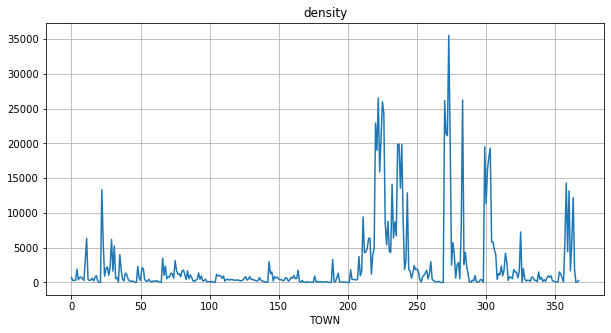

In [183]:
#查看資料分布
plt = tw_density_all["density"].plot(figsize=(10,5))
plt.grid("on", axis="y")
plt.grid("on", axis="x")
plt.set_title("density")
plt.set_xlabel("TOWN")

In [185]:
tw_density_all["density"].describe()

count      368.000000
mean      2624.151223
std       5344.296406
min          4.300000
25%        218.755000
50%        603.660000
75%       1823.012500
max      35541.400000
Name: density, dtype: float64

In [187]:
tw_density = tw_density_all.loc[tw_density_all['density']>5000]
tw_density.head()

TOWN_ID TOWN COUNTY_ID COUNTY   H_CNT   P_CNT   M_CNT   F_CNT INFO_TIME  \
11  10002020  羅東鎮     10002    宜蘭縣   26784   71491   33732   37759   110Y03M   
22  68000010  桃園區     68000    桃園市  178817  458166  221368  236798   110Y03M   
23  68000020  中壢區     68000    桃園市  162107  422726  207073  215653   110Y03M   
29  68000080  八德區     68000    桃園市   76645  209212  104023  105189   110Y03M   
31  68000100  平鎮區     68000    桃園市   81331  228580  113100  115480   110Y03M   

                                             geometry   Area   density  
11  POLYGON ((327078.058 2732874.003, 327083.020 2...  11.28   6337.85  
22  POLYGON ((280446.027 2769485.525, 280455.533 2...  34.34  13342.05  
23  POLYGON ((268712.801 2768286.494, 268712.801 2...  76.09   5555.61  
29  POLYGON ((278416.066 2763576.460, 278413.823 2...  33.78   6193.37  
31  POLYGON ((269293.724 2762234.715, 269293.385 2...  43.47   5258.34

In [188]:
#敘述性統計
tw_density["density"].describe()

count       49.000000
mean     14017.433061
std       7620.633332
min       5258.340000
25%       6394.660000
50%      13184.740000
75%      19865.480000
max      35541.400000
Name: density, dtype: float64

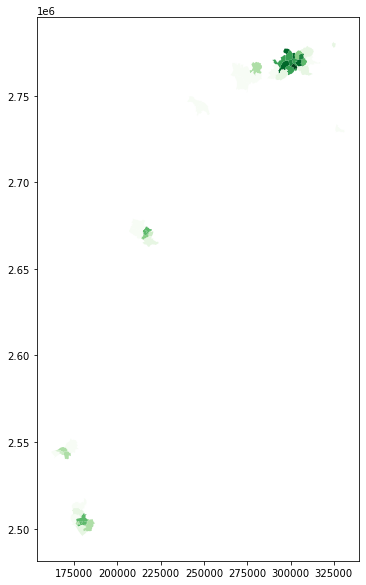

In [189]:
#展圖
tw_density.plot(figsize=(10,10),column='density', scheme="natural_breaks",cmap='Greens', k=10)  #legend=True

## 製作covid案例熱點圖

In [190]:
covid19 = r"/Users/dechuan/Documents/02 Python/2021 NTU Python ３41/covid19_ked_TW/COVID_19_0522.shp"
covid19 = gpd.read_file(covid19,encoding = "UTF-8")
#covid19.head(3)
print(covid19.crs)
covid19[["Name","geometry"]]

epsg:4326


Name                              geometry
0         5/10 臺北車站-基隆  POINT Z (121.51676 25.04752 0.00000)
1    5/10 德義里民活動中心-16樓  POINT Z (121.74625 25.13085 0.00000)
2             5/10 喜萊吉  POINT Z (121.75226 24.75650 0.00000)
3          5/10 輕食早午餐店  POINT Z (121.34471 24.98959 0.00000)
4     5/3、5、10 基隆市立體育館  POINT Z (121.75688 25.12949 0.00000)
..                 ...                                   ...
778            5/12 某店  POINT Z (121.45936 25.00758 0.00000)
779            5/12 某店  POINT Z (121.45889 25.00722 0.00000)
780            5/13 某廟  POINT Z (121.50158 25.00161 0.00000)
781           5/13 某市場  POINT Z (121.50102 25.00050 0.00000)
782        5/13~14 某銀行  POINT Z (121.44218 24.97867 0.00000)

[783 rows x 2 columns]

## 確認座標

In [191]:
tw_density.crs == covid19.crs

False

In [192]:
tw_density84 = tw_density.to_crs(covid19.crs)
tw_density84.crs == covid19.crs

True

## 做互動地圖

In [193]:
# Get x and y coordinates for each point
covid19["x"] = covid19["geometry"].apply(lambda geom: geom.x)
covid19["y"] = covid19["geometry"].apply(lambda geom: geom.y)

# Create a list of coordinate pairs
locations = list(zip(covid19["y"], covid19["x"]))

In [194]:
# 創建Choropleth map階級區分圖所需的Geo-id（每行必須具有唯一的標識符）
tw_density84['geoid'] = tw_density.index.astype(str)

In [197]:
from folium.plugins import HeatMap


m = folium.Map(location=[25.04, 121.53], tiles = 'cartodbpositron', zoom_start=12, control_scale=True)

HeatMap(locations,name='HeatMap Covid-19 Case',radius=30,min_opacity = 0.4,max_zoom = 40).add_to(m)    #假設熱點半徑為30km

folium.Choropleth(geo_data = tw_density84, 
                  data = tw_density84,
                  name='Density>5000人/km²',
                  columns=['geoid','density'],              #資料欄位
                  key_on='feature.id', 
                  fill_color='Greens',                      #Choropleth map色塊
                  line_color='white',                       #Choropleth map線色
                  line_weight=0,                            #Choropleth map線粗                   
                  legend_name= 'Density').add_to(m)         #圖例名稱
                        
    
#工具提示->顯示每個功能的值
folium.features.GeoJson(tw_density84,
                        name='Density label',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},                        
                        tooltip=folium.features.GeoJsonTooltip(
                                      fields=['TOWN','density'],
                                      aliases = ['區域','人口密度(人/km²)'],
                                      labels=True,
                                      sticky=True  #顯示資訊方式不依樣(黏著度)
                                      )
                       ).add_to(m)




# 加入圖層開關功能 layer control 
folium.LayerControl().add_to(m)

m

In [198]:
outfp = "Covid19_TW_20210522.html"
m.save(outfp)